In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
import diffusionstuff10 as ds
from copy import copy as dup
from scipy.integrate import odeint

In [2]:
# Graphics parameters
%matplotlib notebook
ticklabelsize = 11
fontsize = 15
linewidth = 2
fignum = 0

### The cell below specifies parameters for the 0-d and 1-d runs

<IPython.core.display.Javascript object>


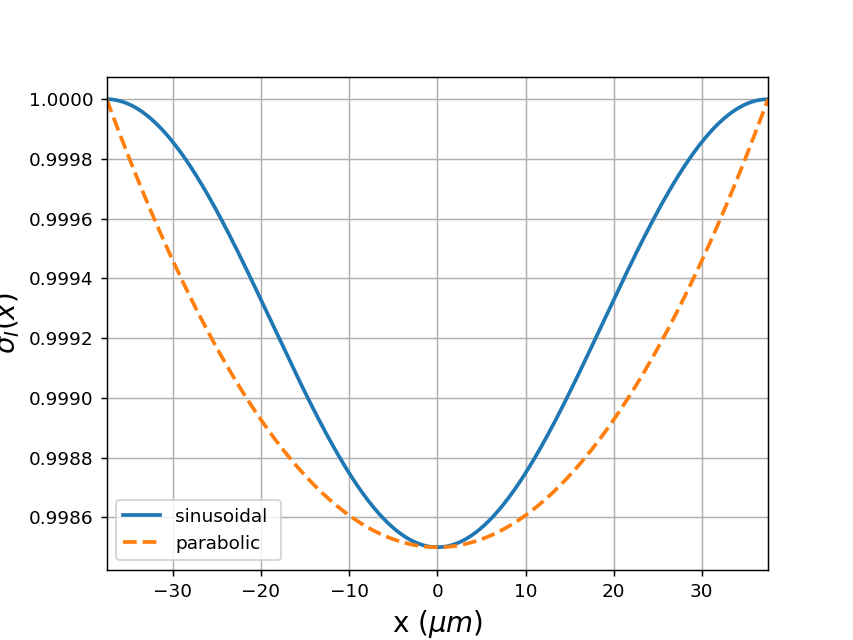

D = 0.0004 um^2/us 0.4 x 10^-9 m^2/sec
deltat_max (Diffusion time) = 56.24999999999999
deltat = 1.1249999999999998
nu_kin_mlyperus = 1.0 monolayers/us
nmid = 250
N* = 0.1432394487827058
N*x2pi = 0.9
Nbar, Nbar-N*, N*/Nbar = 1.0 0.8567605512172942 0.1432394487827058
deltax = 0.15
sigma_0 = 0.19
sigmaIcorner = 0.25
center reduction = 0.15 %
c_r = 0.0015 dimensionless
max growth rate = 75.0 um/sec
min growth rate = 18.0 um/sec
nu_kin = 300 um/sec
dx = 0.15
L = 37.5 micrometers


In [3]:
#Setting up the system
nx = 501 # Number of points in simulation box
xmax = 75
x = np.linspace(0, xmax, nx)
boxpoints = len(x)
deltax = x[1]-x[0]
Nbar = 1.0 # new Nbar from VMD, 260K
Nstar = .9/(2*np.pi)
nmid = int(nx/2)
xmid = max(x)/2
xmax = x[nx-1]
L = xmax/2

# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)

# Diffusion coefficient
# D = 2e-4 # micrometers^2/microsecond
# D = 1.6e-4 # micrometers^2/microsecond
D = 4e-4 # micrometers^2/microsecond
# D = 8e-6 # micrometers^2/microsecond
# D = 2e-7 # micrometers^2/microsecond

# Time steps
dtmaxtimefactor = 50
dtmax = deltax**2/D
t_init = 0.0
deltat = dtmax/dtmaxtimefactor
tinterval = [t_init, t_init+deltat]

# Deposition rate
nu_kin = 34 # microns/second - about right for 240 K
nu_kin = 49 # microns/second - between 240 and 260 K
nu_kin = 250 # microns/second - about right for 260 K
nu_kin = 300 # microns/second - about right for 260 K
nu_kin_mlyperus = nu_kin/umpersec_over_mlyperus # monolayers per microsecond

# Supersaturation
sigma0 = 0.19
sigmaIcorner = 0.20 # Must be bigger than sigma0 to get growth
sigmaIcorner = 0.22 # Must be bigger than sigma0 to get growth
sigmaIcorner = 0.25 # Must be bigger than sigma0 to get growth
center_reduction = 0.25 # In percent
center_reduction = 0.15 # In percent
c_r = center_reduction/100

# Diffusion coefficient scaled for this time step and space step
Doverdeltax2 = D/deltax**2

# Overlying supersaturation
sigmaI_sinusoid = ds.getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='sinusoid')
sigmaI_parabolic = ds.getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='parabolic')
# sigmaIstyle = 'sinusoid'
sigmaIstyle = 'parabolic'
if sigmaIstyle=='sinusoid':
    sigmaI = sigmaI_sinusoid
elif sigmaIstyle=='parabolic':
    sigmaI = sigmaI_parabolic
else:
    print('bad choice')
plt.figure()
plt.plot(x-xmid,sigmaI_sinusoid/sigmaIcorner, \
         x-xmid, sigmaI_parabolic/sigmaIcorner, '--',lw=linewidth)
plt.xlim([-xmid,xmid])
plt.legend(['sinusoidal ', 'parabolic'])
plt.xlabel(r'x ($\mu m$)',fontsize=fontsize)
plt.ylabel(r'$\sigma_I(x) $',fontsize=fontsize)
plt.grid('on')

# 0D run parameters
uselayers = True
if uselayers:
    layermax_0D = 500
else:
    countermax_0D = 100

# 1D run parameters
if uselayers:
    layermax_1D = 15000
else:
    countermax_1D = 15000

# Reporting
print("D =", D, 'um^2/us',D * 1e-12*1e6*1e9, 'x 10^-9 m^2/sec')
print('deltat_max (Diffusion time) =', dtmax)
print('deltat =', deltat)
print('nu_kin_mlyperus =', nu_kin_mlyperus, 'monolayers/us')
print('nmid =', nmid)
print('N* =', Nstar)
print('N*x2pi =', Nstar*2*np.pi)
print('Nbar, Nbar-N*, N*/Nbar =', Nbar, Nbar-Nstar, Nstar/Nbar)
print('deltax =', deltax)
print('sigma_0 =', sigma0)
print('sigmaIcorner =', sigmaIcorner)
print('center reduction =', center_reduction, '%')
print('c_r =', c_r, 'dimensionless')
print('max growth rate =', nu_kin_mlyperus*sigmaIcorner*umpersec_over_mlyperus, 'um/sec')
print('min growth rate =', nu_kin_mlyperus*(sigmaIcorner-sigma0)*umpersec_over_mlyperus, 'um/sec')
print('nu_kin =', nu_kin, 'um/sec')
print('dx =', deltax)
print('L =', L, 'micrometers')

### This is the 0-d run

In [4]:
# Bundle parameters for ODE solver
params = [Nbar, Nstar, sigmaIcorner, sigma0, nu_kin_mlyperus]

# Initialize as a pre-equilibrated layer of liquid over ice
Ntot_init_0D = 1
NQLL_init_0D = ds.getNQLL(Ntot_init_0D,Nstar,Nbar)

# Initialize the keeper arrays
tkeep_0D = []
ykeep_0D = []
tlast = t_init

# Call the ODE solver
ylast = [Ntot_init_0D]
counter = 0
ttot = 0.0
while True:
    
    # Integrate up to next time step
    y = odeint(ds.f0d_1var, ylast, tinterval, args=(params,),rtol=1e-12)
    ylast = list(y[1,:])
    tlast += deltat
    
    # Stuff into keeper arrays
    ykeep_0D.append(ylast)
    tkeep_0D.append(tlast)
    
    # Update counters and see whether to break
    Ntotlast = ylast[0]
    counter += 1
    if uselayers:
        if Ntotlast > layermax_0D-1:
            break
    else:
        if counter > countermax_0D-1:
            break

In [5]:
# Convert results to a numpy array
ykeep_0D = np.array(ykeep_0D, np.float64)
Ntotkeep_0D = ykeep_0D
NQLLkeep_0D = ds.getNQLL(Ntotkeep_0D,Nstar,Nbar)
tkeep_0Darr = np.array(tkeep_0D, np.float64)

0-D Modeled growth rate, um/s [32.59064914]
0-D Modeled growth rate, ml/us [0.1086355]
0-D Modeled alpha [0.43454199]


<IPython.core.display.Javascript object>


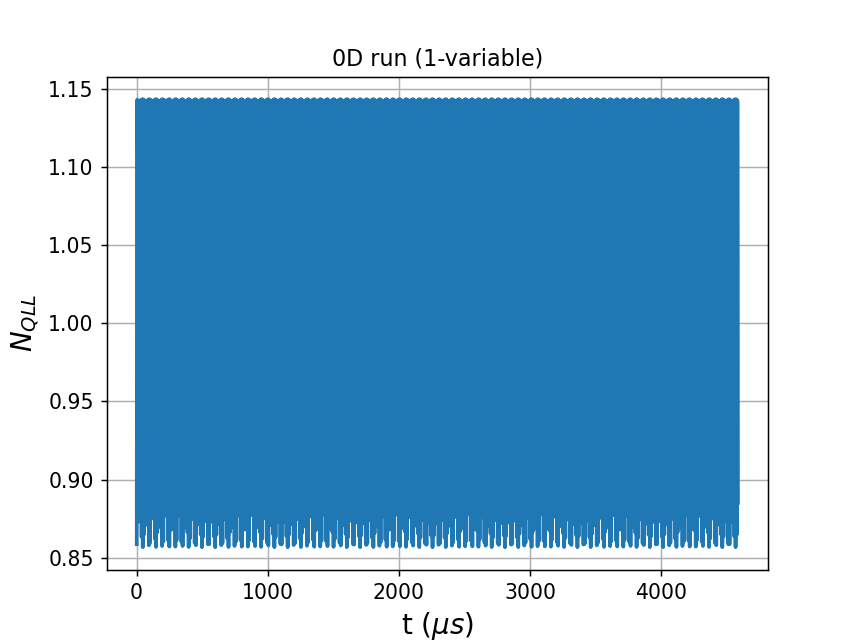

Text(0.5, 1.0, '0D run (1-variable)')

In [6]:
# Growth statistics
delta_Ntot_0D = Ntotkeep_0D[-1]-Ntot_init_0D
growthrate_0D_mlyperus = delta_Ntot_0D/tlast # monolayer/us
growthrate_0D = growthrate_0D_mlyperus*umpersec_over_mlyperus # um/sec
print( "0-D Modeled growth rate, um/s", growthrate_0D)
print( "0-D Modeled growth rate, ml/us", growthrate_0D_mlyperus)
alpha_0D = growthrate_0D/nu_kin/sigmaIcorner
print( "0-D Modeled alpha", alpha_0D)
title = '0D run (1-variable)'

# Plot results
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0D,NQLLkeep_0D,lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')
plt.title(title)

### This is the 1-d run

In [7]:
# Bundle parameters for ODE solver
params = [Nbar, Nstar, sigmaI, sigma0, nu_kin_mlyperus, Doverdeltax2, nx] 

# Initialize as a pre-equilibrated layer of liquid over ice
Ntot_init_1D = np.ones(nx)
NQLL_init_1D = ds.getNQLL(Ntot_init_1D,Nstar,Nbar)

# Initialize the keeper arrays
tkeep_1D = []
ykeep_1D = []
tlast = t_init

# Call the ODE solver
ylast = Ntot_init_1D
counter = 0
layer = 0
ttot = 0.0
while True:
    # Integrate up to next time step
    y = odeint(ds.f1d_1var, ylast, tinterval, args=(params,),rtol=1e-12)
    ylast = list(y[1,:])
    tlast += deltat
    
    # Stuff into keeper arrays
    ykeep_1D.append(ylast)
    tkeep_1D.append(tlast)

    # Make some local copies, with possible updates to NQLL
    ttot += deltat

    # Update counters and see whether to break
    Ntotlast = ylast
    minpoint = min(Ntotlast)
    maxpoint = max(Ntotlast)
    if np.mod(counter,100) == 0:
        print(counter-1, int(Ntotlast[0]), maxpoint-minpoint)
    counter += 1
    if uselayers:
        if Ntotlast[0] > layermax_1D-1:
            break
    else:
        if counter > countermax_1D-1:
            break

-1 1 0.0005180009875098701
99 13 0.04801691587661061
199 25 0.05014491708663371
299 37 0.07139363488012407
399 50 0.16581504660135948
499 62 0.4585255854944137
599 74 0.3620895374434099
699 86 0.20053663719927783
799 98 0.2029855135043448
899 111 0.4142277526771636
999 123 0.7070867546452746
1099 135 0.6949849110359025
1199 147 0.4573590759426338
1299 159 0.3888114632094073
1399 172 0.6998229077842382
1499 184 0.8612698140923101
1599 196 0.8797338668068733
1699 208 0.815393410463173
1799 221 0.724145063218856
1899 233 0.9286426482753996
1999 245 0.9842475332602874
2099 257 1.0084245606890363
2199 269 1.0590731329261303
2299 282 1.24850528573171
2399 294 1.1651038664339808
2499 306 1.1109255184161384
2599 318 1.1306277334775814
2699 331 1.2860975222735078
2799 343 1.5960442646976958
2899 355 1.517503384792633
2999 367 1.2880642756701377
3099 379 1.2802924541028347
3199 392 1.566362283044839
3299 404 1.7857261319517193
3399 416 1.7852138331479068
3499 428 1.6087993847258417
3599 441 1.51

28899 3527 9.062014292504045
28999 3539 9.105184982532137
29099 3552 9.216855256443978
29199 3564 9.105594486519749
29299 3576 8.999747727886643
29399 3588 8.92555520431506
29499 3600 8.882271882769146
29599 3612 8.866130258436897
29699 3624 8.770885173924853
29799 3637 8.696319195154501
29899 3649 8.905433228565471
29999 3661 8.953211219799869
30099 3673 8.955962699101747
30199 3685 8.930371926429416
30299 3698 8.827003067565329
30399 3710 8.822113928059025
30499 3722 8.912038765309262
30599 3734 8.92881772373812
30699 3746 8.913901468792574
30799 3758 8.843744869454895
30899 3770 8.59219672741574
30999 3782 8.311135995963014
31099 3794 8.252372164469762
31199 3807 8.49760660475522
31299 3819 8.741594911780794
31399 3831 8.71536382155955
31499 3843 8.476619880990711
31599 3855 8.311511098414485
31699 3867 8.277148314690294
31799 3879 8.225686758736174
31899 3892 8.223064445384807
31999 3904 8.400546374455189
32099 3916 8.275264349254485
32199 3928 8.125552321983378
32299 3940 8.045709

56899 6901 43.21339735067704
56999 6913 43.465924166458535
57099 6925 43.71423557813796
57199 6937 43.80760473079681
57299 6948 43.81511018743731
57399 6960 43.70723475590148
57499 6972 43.61488248490059
57599 6984 43.84446100731657
57699 6997 44.33398087252317
57799 7009 44.71065697493577
57899 7020 44.899863817299774
57999 7032 44.99307449158914
58099 7044 45.05776977046207
58199 7056 45.25446108084452
58299 7068 45.608325806409994
58399 7080 45.805684394531454
58499 7092 45.90278811326789
58599 7105 45.97274325127364
58699 7117 46.07735848237371
58799 7129 46.317048829240775
58899 7141 46.702639592237574
58999 7153 46.93255198280349
59099 7165 47.06052236307369
59199 7177 47.137049753530846
59299 7189 47.26223174592997
59399 7202 47.538992497182335
59499 7214 48.06999453150638
59599 7226 48.620651566156084
59699 7237 48.874539460389315
59799 7249 48.99318713067623
59899 7261 49.08321199232341
59999 7273 49.29365965999932
60099 7285 49.68000778199348
60199 7297 49.92557451707307
6029

84899 10268 51.04022766517119
84999 10280 50.949573616700945
85099 10292 50.8254583093003
85199 10304 50.504113113011044
85299 10316 50.112382807225
85399 10328 50.00334636465959
85499 10340 49.870276145564276
85599 10353 49.514083774276514
85699 10365 49.16263064219493
85799 10377 48.94801572765209
85899 10389 48.6038917741771
85999 10401 48.2342896879818
86099 10413 48.14530039372403
86199 10425 48.02710178147936
86299 10438 47.812995668960866
86399 10450 47.44454178406704
86499 10462 47.23369975827882
86599 10474 47.20302956932392
86699 10486 47.09811589747551
86799 10498 46.84955247370635
86899 10510 46.46099914573642
86999 10523 46.195645978057655
87099 10535 46.08767590776915
87199 10547 46.02429310496518
87299 10559 45.90122942142261
87399 10571 45.64938360571978
87499 10583 45.24700308179672
87599 10596 45.074618536880735
87699 10608 44.99381357284801
87799 10620 44.87855274001049
87899 10632 44.60107258109929
87999 10644 44.204537490211806
88099 10656 44.05681347333666
88199 1

111699 13502 44.707680009290925
111799 13514 44.73679935839755
111899 13527 44.67500574239966
111999 13539 44.69840264088816
112099 13551 44.86857082554161
112199 13563 44.91207193226546
112299 13575 44.92016502045226
112399 13587 44.92281082936461
112499 13599 44.9249955882151
112599 13611 44.94708021776569
112699 13623 45.04518531694339
112799 13635 45.401817356349056
112899 13647 45.752471038356816
112999 13659 45.96713326958525
113099 13671 46.13741497956835
113199 13683 46.27542521944997
113299 13695 46.27840992585516
113399 13707 46.15609695753119
113499 13719 45.998476775997915
113599 13731 45.91613888168649
113699 13743 45.96319740007311
113799 13755 46.055379695961165
113899 13767 46.160027086674745
113999 13779 46.251980527154956
114099 13791 46.29194680161345
114199 13804 46.509032542295245
114299 13816 46.822641246692
114399 13828 46.82140025081753
114499 13840 46.553332451932874
114599 13851 46.32270984109164
114699 13863 46.19082803188212
114799 13875 46.14816544527821
11

In [8]:
# Convert results to a numpy array
ykeep_1D = np.array(ykeep_1D, np.float64)
Ntotkeep_1D = ykeep_1D
NQLLkeep_1D = ds.getNQLL(Ntotkeep_1D,Nstar,Nbar)
tkeep_1Darr = np.array(tkeep_1D, np.float64)

1-D growth rate, ml/us 0.10737589286170023
1-D growth rate, um/s 32.21276785851007
1-D alpha 0.4295035714468009
slowdown -1.15 %
Libbrecht's predicted growth rate 15.24912977854751 um/s
Libbrecht's predicted alpha 0.20332173038063348


<IPython.core.display.Javascript object>


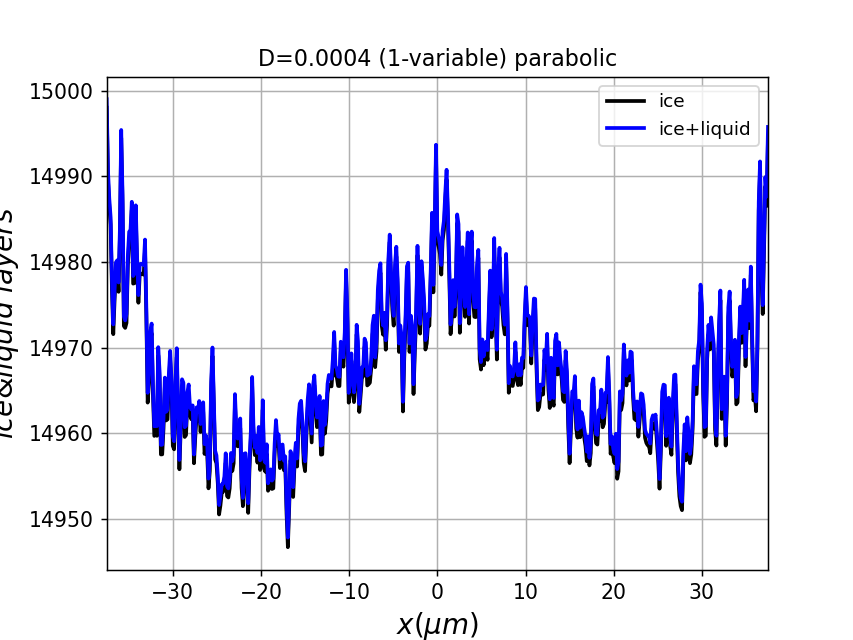

<IPython.core.display.Javascript object>


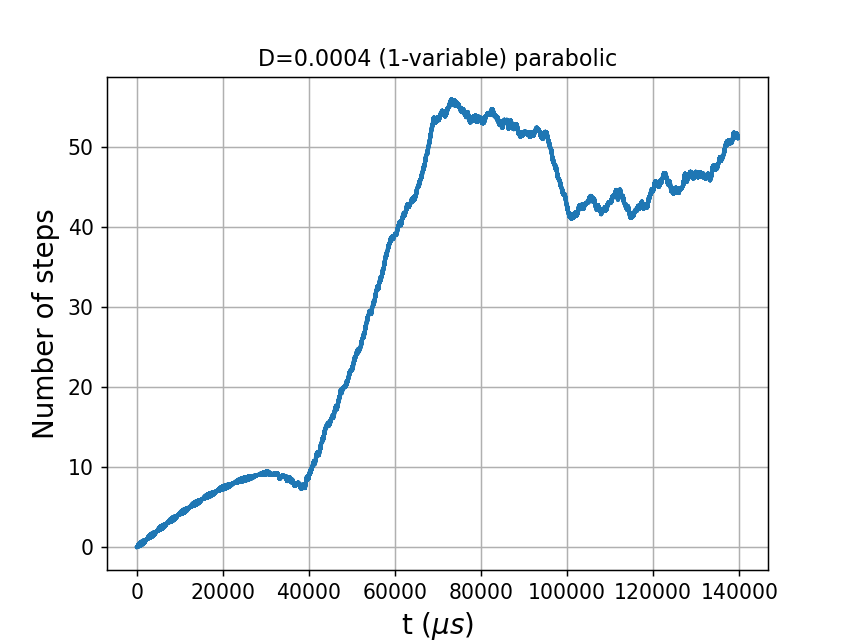

<IPython.core.display.Javascript object>


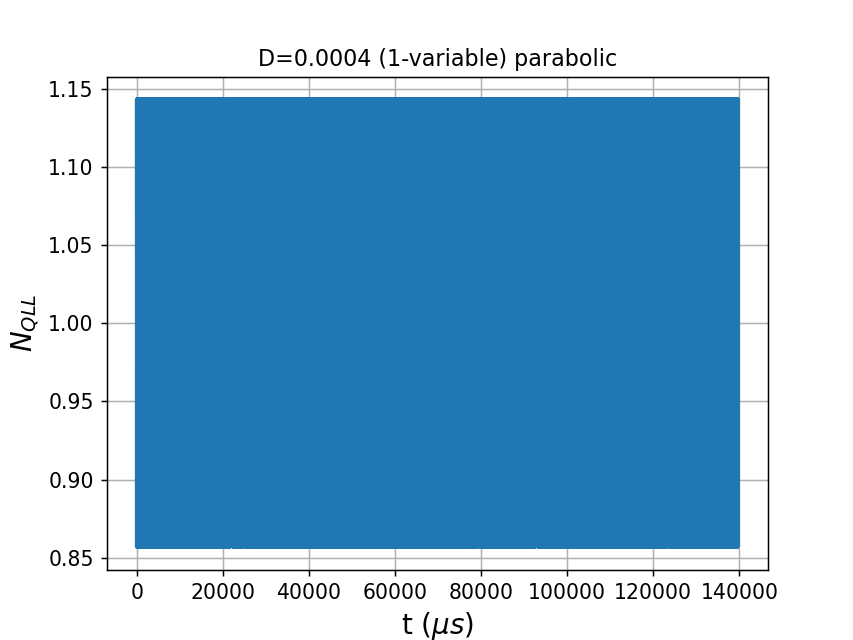

In [9]:
# Growth statistics
delta_Ntot_1D = Ntotkeep_1D[-1,0]-Ntotkeep_1D[0,0]
growthrate_1D_mlyperus = delta_Ntot_1D/tlast; print( "1-D growth rate, ml/us", growthrate_1D_mlyperus)
growthrate_1D = growthrate_1D_mlyperus*umpersec_over_mlyperus; print( "1-D growth rate, um/s", growthrate_1D)
alpha_1D = growthrate_1D/nu_kin/sigmaIcorner; print( "1-D alpha", alpha_1D)
slowdown = (alpha_1D-alpha_0D)/alpha_0D*100; print("slowdown", int(slowdown*100)/100,'%')
Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D
title = 'D='+str(D)+' (1-variable) '+sigmaIstyle

# Comparisons with Libbrecht
sigma0_L = 0.08
A_L = .28
alpha_L = A_L*np.exp(-sigma0_L/sigmaIcorner)
print("Libbrecht's predicted growth rate", nu_kin*alpha_L*sigmaIcorner, "um/s")
print("Libbrecht's predicted alpha", alpha_L)

# Plot ice and liquid, last time step
plt.figure()
plt.plot(x-xmid, Nicekeep_1D[-1,:], 'k', label='ice', lw=linewidth)
plt.plot(x-xmid, Ntotkeep_1D[-1,:], 'b', label='ice+liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice & liquid \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# Plot number of steps over time
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
f = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
plt.plot(tkeep_1D,f,lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel('Number of steps',fontsize=fontsize)
plt.title(title)
plt.grid('on')

# Plot QLL over time, at the corner
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_1D,NQLLkeep_1D[:,0],lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.title(title)
plt.grid('on')

### The cell below is just backup for parameters, and allows some exploration (but not part of the simulation)

In [10]:
# The time required for an initial gaussian to diffuse
layer_growth_rate = growthrate_0D/umpersec_over_mlyperus; print('Layer growth rate =', layer_growth_rate)
t1 = 1/layer_growth_rate; print('Time_to_add_a_layer =', t1)
t2 = 2.5**2/D; print('Time to diffuse across a terrace =', t2)
t3 = 0.2**2/D; print('Time to diffuse into a step =', t3)
t4 = 0.001; print('Time for ice-QLL equilibration =', t4)

# How a change in the crystal size could be used to calculate a new diffusion coefficient with the same D/dx^2
D_old = 2e-6
D_new = D_old/50**2*100**2; print(D_new)

# Computing the kinetic deposition velocity ... roughly, 260 
import numpy as np
M = 18 # g/mol
T = 260 # K
NA = 6.02e23
m = M/NA; print(m,'mass of a molecule of water, grams/mol')
m /= 1e3; print(m,'mass of a molecule of water, kg/mol')
R = 8.314 # J/K-mol
k = R/NA; print(k,"Boltzmann's constant, J/K")

Pvap = 200 # Pascals (see https://byjus.com/clausius-clapeyron-equation-calculator/)
V_gas = R*T/Pvap # Must be in m^3
V_gas *= (10/1)**3; print(V_gas, 'Liters') 
V_gas *= (10/1)**3; print(V_gas, 'cm^3') # see https://www.omnicalculator.com/physics/ideal-gas-law
c_sat = 1/V_gas # mol/cm^3
c_sat*=M; print(c_sat,'density of vapor, g/cm^3')

c_solid = 0.92; print(c_solid, 'density of ice, g/cm^3')
V_solid = 1/c_solid # cm^3/g

V_ratio = V_gas/V_solid; print(V_ratio,'ratio of volumes')
c_ratio = c_sat/c_solid; print(c_ratio,'ratio of densities')

sqrtfactor = np.sqrt(k*T/(2*np.pi*m))
nukin = c_sat/c_solid*sqrtfactor; print(nukin,'kinetic velocity, m/s')
nukin *= 1e6; print(nukin, 'kinetic velocity, um/s')

# Computing the kinetic deposition velocity ... roughly, 240 K has nukin of 40 um/s (we used 49 um/s in the paper)
M = 18 # g/mol
T = 240 # K
NA = 6.02e23
m = M/NA; print(m,'mass of a molecule of water, grams/mol')
m /= 1e3; print(m,'mass of a molecule of water, kg/mol')
R = 8.314 # J/K-mol
k = R/NA; print(k,"Boltzmann's constant, J/K")

Pvap = 26 # Pascals (see https://byjus.com/clausius-clapeyron-equation-calculator/)
V_gas = R*T/Pvap # Must be in m^3
V_gas *= (10/1)**3; print(V_gas, 'Liters') 
V_gas *= (10/1)**3; print(V_gas, 'cm^3') # see https://www.omnicalculator.com/physics/ideal-gas-law
c_sat = 1/V_gas # mol/cm^3
c_sat*=M; print(c_sat,'density of vapor, g/cm^3')

c_solid = 0.92; print(c_solid, 'density of ice, g/cm^3')
V_solid = 1/c_solid # cm^3/g

V_ratio = V_gas/V_solid; print(V_ratio,'ratio of volumes')
c_ratio = c_sat/c_solid; print(c_ratio,'ratio of densities')

sqrtfactor = np.sqrt(k*T/(2*np.pi*m))
nukin = c_sat/c_solid*sqrtfactor; print(nukin,'kinetic velocity, m/s')
nukin *= 1e6; print(nukin, 'kinetic velocity, um/s')

# Gladich et al recommendation
D_Gladich = 0.16e-9 # m^2/s
D_Gladich *= (1e6/1)**2*(1/1e6); print('Gladich says, for 260 K, D = ', D_Gladich)

Layer growth rate = [0.1086355]
Time_to_add_a_layer = [9.20509434]
Time to diffuse across a terrace = 15625.0
Time to diffuse into a step = 100.00000000000001
Time for ice-QLL equilibration = 0.001
8e-06
2.990033222591362e-23 mass of a molecule of water, grams/mol
2.9900332225913625e-26 mass of a molecule of water, kg/mol
1.381063122923588e-23 Boltzmann's constant, J/K
10808.199999999999 Liters
10808199.999999998 cm^3
1.6654021946300035e-06 density of vapor, g/cm^3
0.92 density of ice, g/cm^3
9943543.999999998 ratio of volumes
1.810219776771743e-06 ratio of densities
0.0002502630900698087 kinetic velocity, m/s
250.26309006980867 kinetic velocity, um/s
2.990033222591362e-23 mass of a molecule of water, grams/mol
2.9900332225913625e-26 mass of a molecule of water, kg/mol
1.381063122923588e-23 Boltzmann's constant, J/K
76744.61538461539 Liters
76744615.38461539 cm^3
2.345441424103921e-07 density of vapor, g/cm^3
0.92 density of ice, g/cm^3
70605046.15384616 ratio of volumes
2.549392852286